<a id='head'></a>
## Mouse Pancreas scRNA-seq Analysis

by Wesley Lewis and Vimig Socrates

This analysis primarily makes use of scVelo and scHPF:

Data is from the scVelo Dynamic Velocity tutorial:

scRNA-seq originally sourced from:



### Navigation Links:

[Head](#head)

[Downloading and Pre-processing Data](#data)
    
[scHPF commands](#schpfcom)

[scHPF analysis](#schpfanal)

[RNA Velocity analysis (scVelo)](#another_cell)

[Summary](#another_cell)

In [59]:
import numba
import sklearn
import pandas
import loompy
import numpy as np
import scanpy as sc
import scprep
import phate

In [2]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.2 (python 3.6.9) on 2020-12-18 19:07.


In [3]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

<a id='data'></a>
### Downloading and Pre-processing Data

In [4]:
adata = scv.datasets.pancreas()

In [5]:
adata2 = adata.copy()

In [6]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


<a id='schpfcom'></a>
## Now run scHPF on the count matrix

1: Prepare and save un-normalized matrix

2: Save variables for scHPF commands - note that these files are enclosed within scHPF package install folder

3: Run prep command

In [7]:
#create dense matrix from sparse
densemat = adata2.X.todense().T.astype(int)
i = densemat.shape[0] ; j = densemat.shape[1]
print(densemat.shape)
print(i, j)
#create new numpy object with additional dimensions for scHPF vars
hpfmat = np.empty(shape=(i,j+2),dtype=object)
print(hpfmat.shape)

(27998, 3696)
27998 3696
(27998, 3698)


In [8]:
#get list of genes/vars from the original matrix
adata2.var.shape #this is the number of genes. should match the first dim of both matrixes
adata2.var.index
#fill in the new matrix
hpfmat[:,0]=adata2.var.index #since these are already ensmble IDs the two cols are equivalent
hpfmat[:,1]=adata2.var.index
hpfmat[:,2:]=densemat
hpfmat

array([['Xkr4', 'Xkr4', 0, ..., 0, 0, 0],
       ['Gm37381', 'Gm37381', 0, ..., 0, 0, 0],
       ['Rp1', 'Rp1', 0, ..., 0, 0, 0],
       ...,
       ['Gm29504', 'Gm29504', 0, ..., 0, 0, 0],
       ['Gm20837', 'Gm20837', 0, ..., 0, 0, 0],
       ['Erdr1', 'Erdr1', 0, ..., 0, 0, 0]], dtype=object)

In [9]:
#save hpfmat
np.savetxt("/data/tapedir/notebooks/HPF_Project/hpfmat.csv", hpfmat, fmt="%s", delimiter=" ")

In [10]:
whitelist = "/data/tapedir/notebooks/HPF_Project/scHPF/resources/gencode.vM19.annotation.gene_l1l2.pc_TRC_IGC.stripped.txt"
countmatrix ="/data/tapedir/notebooks/HPF_Project/hpfmat.csv"
outdir = "/data/tapedir/notebooks/HPF_Project/hpf-out"

In [14]:
#running scHPF
!scHPF prep -i {countmatrix} -o {outdir} -m 10 -w {whitelist} --filter-by-gene-name

Loading data.....
	loaded 10000 genes for 3696 cells
	loaded 20000 genes for 3696 cells
.....found 3696 cells and 27998 genes
Generating masks for filtering.....
Filtering data.....
Writing filtered data to file.....
Writing commandline arguments to file.....


In [15]:
prefix = "Pancreas"
prepfile = "/data/tapedir/notebooks/HPF_Project/hpf-out/filtered.mtx"

In [16]:
!scHPF train -i {prepfile} -o {outdir} -p {prefix} -k 7 -t 5

Loading data.....
.....found 3696 cells and 12170 genes in /data/tapedir/notebooks/HPF_Project/hpf-out/filtered.mtx
Running trials.....
[Iter.    0]  loss:17.673517  pct:100.000000000
[Iter.   10]  loss:2.278410  pct:-87.108337068
[Iter.   20]  loss:2.169655  pct:-4.773284586
[Iter.   30]  loss:2.084631  pct:-3.918772343
[Iter.   40]  loss:2.067968  pct:-0.799327803
[Iter.   50]  loss:2.058129  pct:-0.475792285
[Iter.   60]  loss:2.054124  pct:-0.194620569
[Iter.   70]  loss:2.052274  pct:-0.090047304
[Iter.   80]  loss:2.051229  pct:-0.050895589
[Iter.   90]  loss:2.050585  pct:-0.031433867
[Iter.  100]  loss:2.050127  pct:-0.022330123
[Iter.  110]  loss:2.049741  pct:-0.018809230
[Iter.  120]  loss:2.049311  pct:-0.020978323
[Iter.  130]  loss:2.048855  pct:-0.022245342
[Iter.  140]  loss:2.048407  pct:-0.021890244
[Iter.  150]  loss:2.047862  pct:-0.026582177
[Iter.  160]  loss:2.046895  pct:-0.047217174
[Iter.  170]  loss:2.046167  pct:-0.035563737
[Iter.  180]  loss:2.045527  pct:

[Iter.  160]  loss:2.037671  pct:-0.005824464
[Iter.  170]  loss:2.037571  pct:-0.004889933
[Iter.  180]  loss:2.037457  pct:-0.005617623
[Iter.  190]  loss:2.037370  pct:-0.004257158
[Iter.  200]  loss:2.037330  pct:-0.001971232
[Iter.  210]  loss:2.037289  pct:-0.001988183
[Iter.  220]  loss:2.037272  pct:-0.000846070
[Iter.  230]  loss:2.037253  pct:-0.000963764
converged
Trial 4 loss: 2.037253
Best loss: 2.031543 (trial 3)
Saving best model (7 factors).....
Writing commandline arguments to file.....
/data/tapedir/notebooks/HPF_Project/hpf-out/Pancreas.train_commandline_args.json




Output a gene x cell score matrix and a ranked gene list for further analyses:

In [18]:
model = "/data/tapedir/notebooks/HPF_Project/hpf-out/Pancreas.scHPF_K7_b0_5trials.joblib"

!scHPF score -m {model} -o {outdir} -p {prefix}

Loading model.....
Calculating scores.....
Saving scores.....
Calculating mean cellscore fractions.....
Calculating maximum pairwise overlaps.....
Writing commandline arguments to file.....


Output a ranked list of gene names with scores for each factor:

In [19]:
#To also generate a tab-delimited file of gene names, ranked by gene-score for each factor:
genesfile = "/data/tapedir/notebooks/HPF_Project/hpf-out/genes.txt"
!scHPF score -m {model} -o {outdir} -p {prefix} -g {genesfile}

Loading model.....
Calculating scores.....
Saving scores.....
Calculating mean cellscore fractions.....
Calculating maximum pairwise overlaps.....
Ranking genes.....
.....using 1'th column of genefile as gene label
Saving ranked genes.....
Writing commandline arguments to file.....


<a id='schpfanal'></a>
### Analyze scHPF and Pancreas Data

1. Overlaying HPF cell scores onto data embeddings
2. Calculating RNA Velocity
3. Comparing with real programming identified by RNA velocity
    - Idea is, if real biological programs are being pulled out of the static timepoint scRNA-seq data with HPF, they should be somewhat consistent with the additional spatial components of RNA velocity

In [21]:
#scHPF output paths
gene_scores = "/data/tapedir/notebooks/HPF_Project/hpf-out/Pancreas.gene_score.txt"
cell_scores = "/data/tapedir/notebooks/HPF_Project/hpf-out/Pancreas.cell_score.txt"
ranked_genes = "/data/tapedir/notebooks/HPF_Project/hpf-out/Pancreas.ranked_genes.txt"

In [30]:
gscores = np.loadtxt(gene_scores)
cscores = np.loadtxt(cell_scores) 
rgenes = np.loadtxt(ranked_genes,dtype=str)

print(gscores.shape) #genes by factors
print(cscores.shape) #cells by factors
print(rgenes.shape) #genes by factors (as string of gene names)

(12170, 7)
(3696, 7)
(12170, 7)


### Give each cell a score for each factor in each adata object

- Edit both adata and adata2 .obs matrixes

In [34]:
newcols = ["f1","f2","f3","f4","f5","f6","f7"]
c=0
for i in newcols:
    adata.obs[i]=cscores[:,c]
    adata2.obs[i]=cscores[:,c]
    c=c+1

In [41]:
adata.obs.iloc[:3,-7:]

,f1,f2,f3,f4,f5,f6,f7
index,,,,,,,
AAACCTGAGAGGGATA,0.000250,1.950546,0.000342,0.775351,0.000205,0.103975,0.267835
AAACCTGAGCCTTGAT,0.674096,0.007060,0.000263,0.005001,1.489191,0.011215,0.912008
AAACCTGAGGCAATTA,0.030326,1.875743,0.411268,0.167641,0.031902,0.000326,0.580840


In [42]:
adata2.obs.iloc[:3,-7:]

,f1,f2,f3,f4,f5,f6,f7
index,,,,,,,
AAACCTGAGAGGGATA,0.000250,1.950546,0.000342,0.775351,0.000205,0.103975,0.267835
AAACCTGAGCCTTGAT,0.674096,0.007060,0.000263,0.005001,1.489191,0.011215,0.912008
AAACCTGAGGCAATTA,0.030326,1.875743,0.411268,0.167641,0.031902,0.000326,0.580840


We can use the adata.obs['clusters'] specific cell type/cluster identity labels to overlay cluster identity on multiple types of embeddings.

Let's use PCA, UMAP, and PHATE.

    -PCA
    Use existing PCA's (from the loaded matrix)
    -UMAP
    Use existing UMAP coords (from the loaded matrix)
    -PHATE
    Calculate PHATE

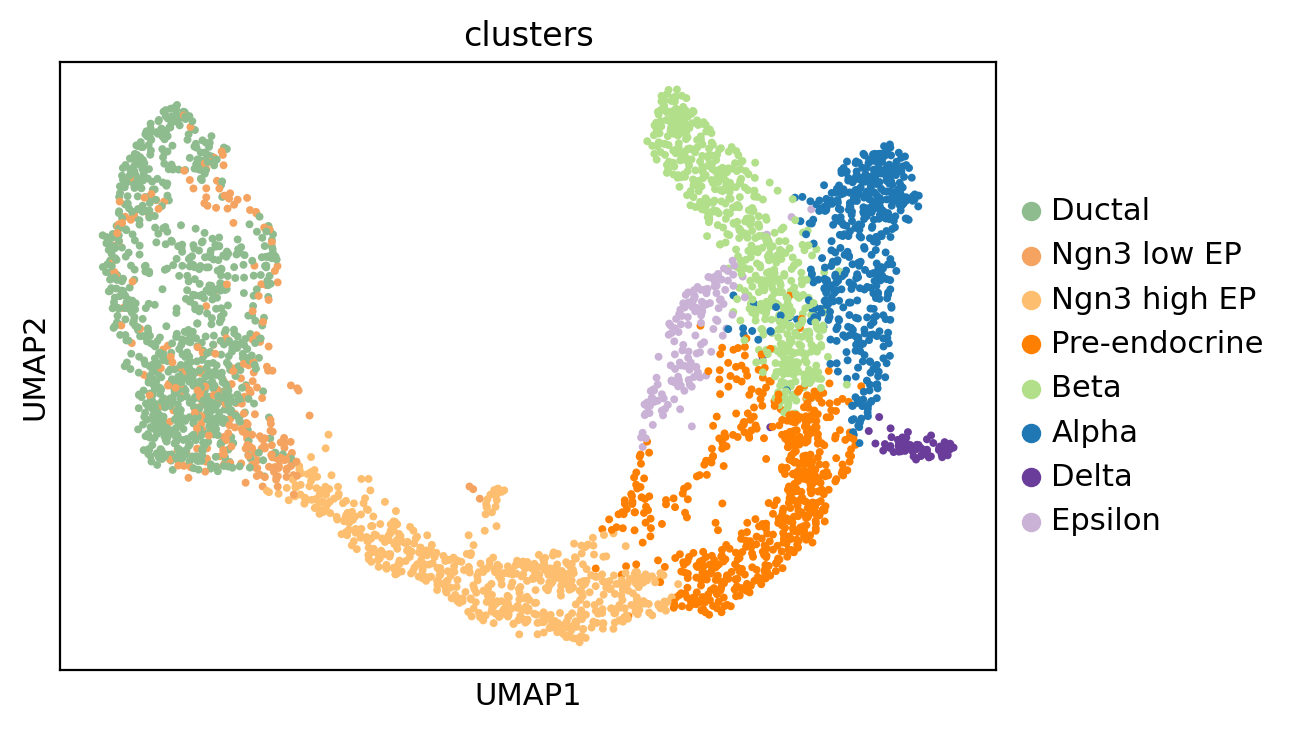

In [51]:
sc.pl.umap(adata,color='clusters')

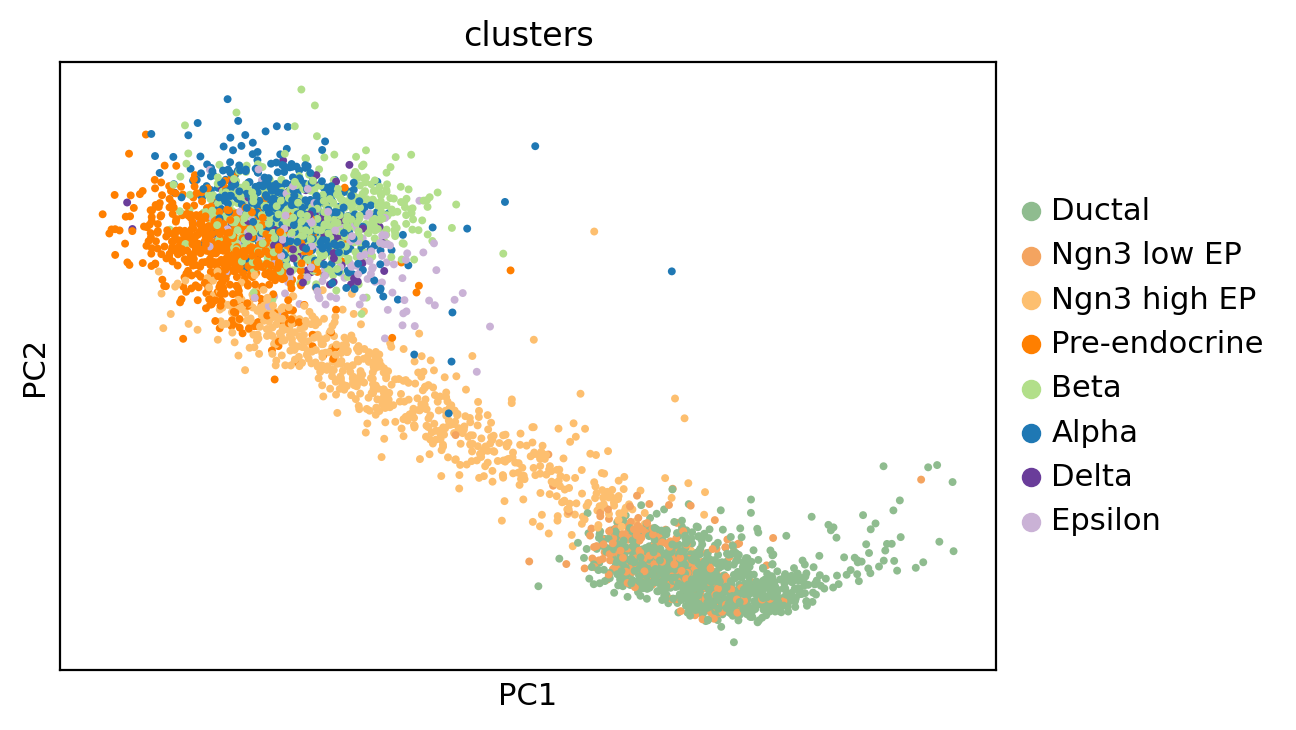

In [55]:
sc.pl.pca(adata,color='clusters')

In [52]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [60]:
#calculate phate
counts = scprep.transform.sqrt(adata2.X)
phate_operator = phate.PHATE(n_jobs=-2)

Y_phate = phate_operator.fit_transform(counts)

Calculating PHATE...
  Running PHATE on 3696 observations and 27998 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.25 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.85 seconds.
    Calculating affinities...
    Calculated affinities in 0.15 seconds.
  Calculated graph and diffusion operator in 9.27 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.35 seconds.
    Calculating KMeans...
    Calculated KMeans in 29.89 seconds.
  Calculated landmark operator in 32.30 seconds.
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 5.37 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.56 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.47 seconds.
Calculated PHATE in 53.98 seconds.


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

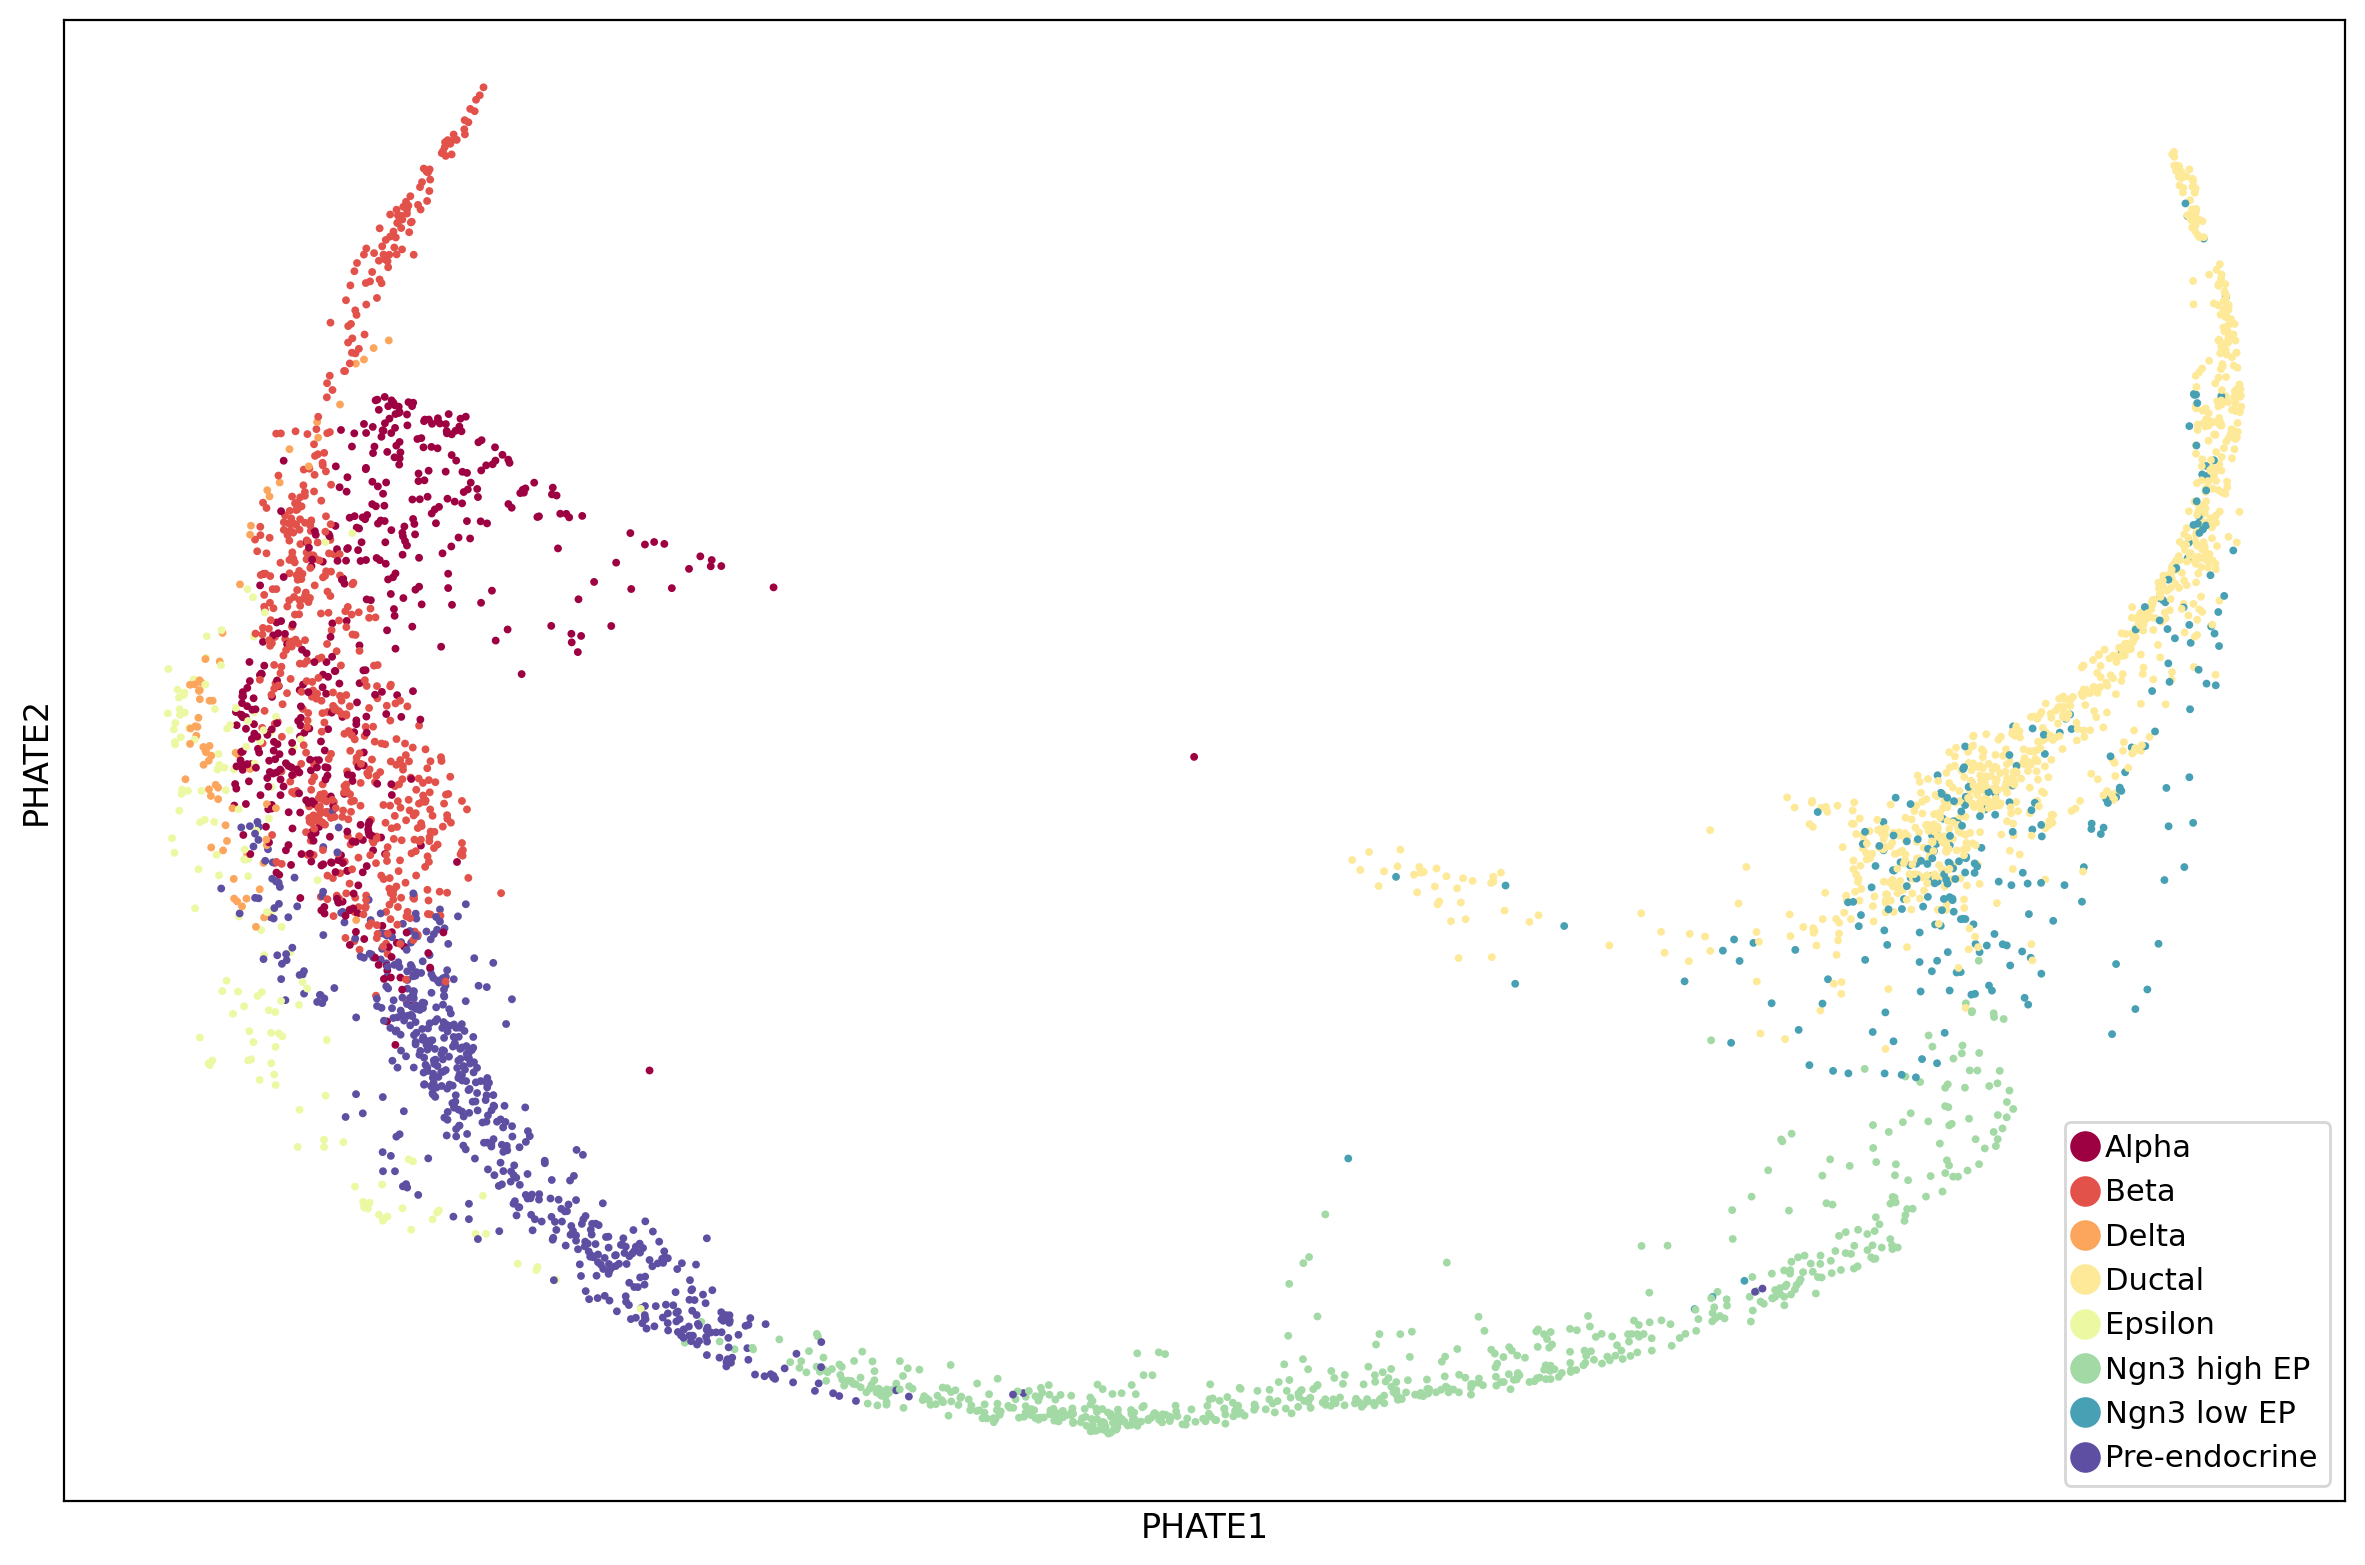

In [62]:
scprep.plot.scatter2d(Y_phate, c=adata.obs['clusters'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

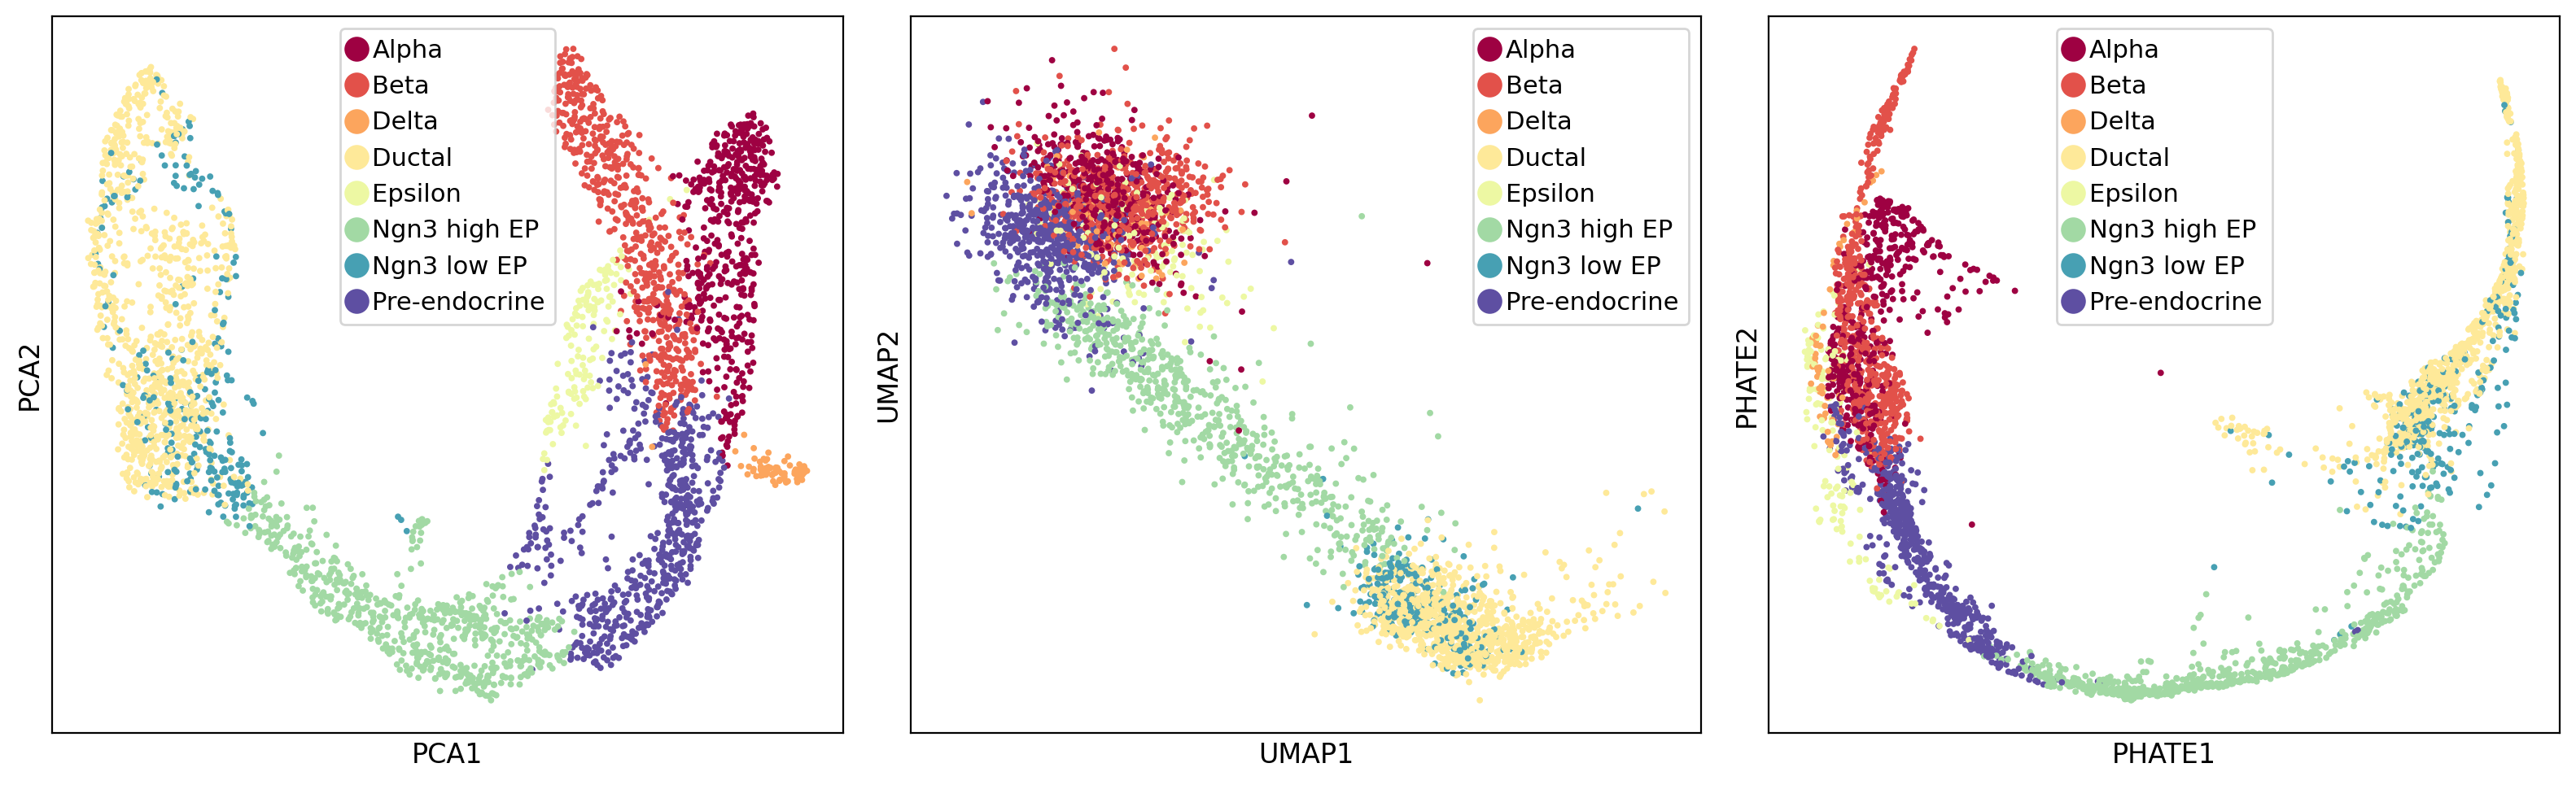

In [69]:
# plot all three
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 5))


scprep.plot.scatter2d(adata.obsm['X_umap'],c=adata.obs['clusters'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="PCA",ax=ax1)
scprep.plot.scatter2d(adata.obsm['X_pca'],c=adata.obs['clusters'], figsize=(12,8), cmap="Spectral",ticks=False, label_prefix="UMAP",ax=ax2)
scprep.plot.scatter2d(Y_phate, c=adata.obs['clusters'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE", ax=ax3)

plt.tight_layout()
plt.show()

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'